In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from sghmc.module import sghmc,sghmc_chains

# $U(\theta)=-2\theta^2+\theta^4$ and $\nabla \tilde{U}=\nabla U + N(0,4)$

In [3]:
def su_glpdf(y,theta):
    g = -(-4*theta+4*theta**3)
    
    return g/50

def su_glpr(theta):
    return 0

In [4]:
eps=0.1
batch_size = 1
simsu = sghmc(su_glpdf, su_glpr, np.zeros((50*batch_size,1)), V_hat = np.eye(1)*0, eps = eps, 
            theta_0 = np.array([0]), C = np.eye(1)*2*eps, 
            heatup = 100, epoches = 2000, batch_size = batch_size)

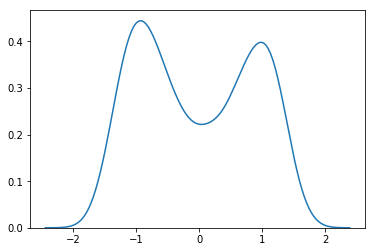

In [5]:
sns.kdeplot(simsu[:,0])
plt.savefig('simpleU.png')

# Mixture Normal

In [6]:
mu = np.array([-3, 3]).reshape(2,1) # true value for mu
n = 200 # number of observations
y = np.r_[np.random.normal(mu[0], 1, n),np.random.normal(mu[1], 1, n)]

In [7]:
def mn_glpdf(y,mu):
    exp1=np.exp(-0.5*(y-mu[0])**2)
    exp2=np.exp(-0.5*(y-mu[1])**2)
    
    v = np.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]
    return np.sum(v/(exp1+exp2),axis=0)

def mn_glpr(mu):
    return -(np.sum(mu)/100)

In [8]:
%%time
sim1 = sghmc(mn_glpdf, mn_glpr, y[:,None], V_hat = np.eye(2), eps = 0.01, 
            theta_0 = np.array([0,0]), C = np.eye(2), 
            heatup = 100, epoches = 200, batch_size = 80)


CPU times: user 84.6 ms, sys: 7.65 ms, total: 92.2 ms
Wall time: 90.8 ms


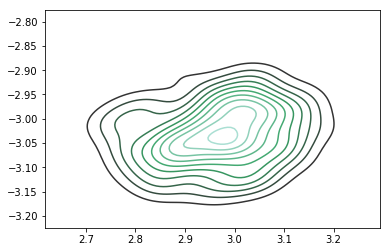

<Figure size 432x288 with 0 Axes>

In [9]:
kdeplt2 = sns.kdeplot(sim1[:,0],sim1[:,1])  
plt.show()
plt.savefig('mixnom1.png')

In [10]:
%%time
sim2 = sghmc_chains(mn_glpdf, mn_glpr, y[:,None], V_hat = np.eye(2), eps = 0.01, 
            theta_0 = np.array([0,0]), C = np.eye(2), 
            heatup = 100, epoches = 200, batch_size = 80,chain = 20)
sim2 = np.r_[tuple([asim for asim in sim2])]

CPU times: user 27.4 ms, sys: 83.1 ms, total: 111 ms
Wall time: 685 ms


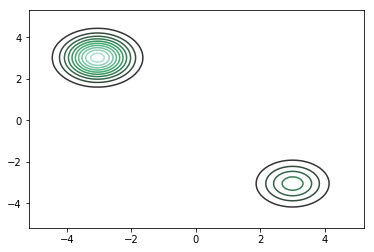

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

kdeplt2 = sns.kdeplot(sim2[:,0],sim2[:,1])  
plt.show()
plt.savefig('mixnom2.png')

# Bayesian Neural Network

perform bayesian neural network regression on MPG(https://archive.ics.uci.edu/ml/index.php) data.

In [12]:
import pandas as pd

In [13]:
# codes loading MPG comes from keras tutorial
datapd = pd.read_csv('auto-mpg.data', names=['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'],
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
datapd.tail()
datapd = datapd.dropna()
origin = datapd.pop('Origin')
datapd['USA'] = (origin == 1)*1.0
datapd['Europe'] = (origin == 2)*1.0
datapd['Japan'] = (origin == 3)*1.0

In [98]:
#standardize
sd = np.max(datapd[['Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year']],axis=0)
datapd[['Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year']]/=sd

In [99]:
train_dataset = datapd.sample(frac=0.8,random_state=0)
test_dataset = datapd.drop(train_dataset.index)

In [100]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,28.0,0.5,0.197802,0.326087,0.413424,0.584677,0.902439,1.0,0.0,0.0
282,22.3,0.5,0.307692,0.382609,0.562257,0.697581,0.963415,1.0,0.0,0.0
69,12.0,1.0,0.769231,0.695652,0.866926,0.544355,0.878049,1.0,0.0,0.0
378,38.0,0.5,0.230769,0.273913,0.413424,0.592742,1.000000,1.0,0.0,0.0
331,33.8,0.5,0.213187,0.291304,0.417315,0.725806,0.975610,0.0,0.0,1.0


The network contains a hidden layer with 10 nodes and an output layer

In [101]:
def generate_grad_lpdf(xdim,nnodes,sgmsq):
    def expit(x):
        return 1/(1+np.exp(-x))
    
    def dexpit(x):
        epx=expit(x)
        return epx*(1-epx)
    
    def grad_lpdf(data,theta):
        Beta=np.c_[tuple(np.split(theta[nnodes+1:],nnodes))]
        Y=data[:,0]
        X=np.c_[np.ones(data.shape[0]),data[:,1:]]
        IN=X@Beta
        V=expit(IN)
        betau=theta[:nnodes+1]
        u=betau[0]+V@betau[1:]
        dIN=dexpit(-IN)
        buidexp=dIN*betau[1:]
        gU = np.c_[tuple([buidexp[:,[i]]*X for i in range(nnodes)])]
        gU = np.c_[np.ones(data.shape[0]),V,gU]
        gU = (Y-u)[:,None]/sgmsq*gU
        return np.sum(gU,axis=0)
        
    return grad_lpdf

def generate_grad_lprior(xdim,nnodes,sgmsqbh,sgmsqbu):
    def grad_lprior(theta):
        return -np.r_[theta[:nnodes+1]/sgmsqbu,theta[nnodes+1:]/sgmsqbh]
    return grad_lprior

def generate_predict_func(xdim,nnodes):
    def expit(x):
        return 1/(1+np.exp(-x))
    
    def a_predict(adata,theta):
        Beta=np.c_[tuple(np.split(theta[nnodes+1:],nnodes))]
        X=np.r_[1,adata]
        IN = Beta.T@X
        V=expit(IN)
        betau=theta[:nnodes+1]
        u=betau[0]+np.dot(V,betau[1:])
        return u
    
    def m_predict(adata,theta_sim):
        return np.mean(np.array([a_predict(adata,theta) for theta in theta_sim]))
        
    def predict(data,theta_sim):
        return np.array([m_predict(adata,theta_sim) for adata in data])
        
    return predict

def form_data(y,x):
    return np.c_[y,x]

In [106]:
xdim=9
nnodes=10
sgmsq=1
sgmsqbh=1
sgmsqbu=1

data = form_data(train_dataset.MPG,train_dataset.drop('MPG',axis=1))

nn_glpdf=generate_grad_lpdf(xdim,nnodes,sgmsq)
nn_glprior=generate_grad_lprior(xdim,nnodes,sgmsqbh,sgmsqbu)
predict=generate_predict_func(xdim,nnodes)

In [134]:
thetadim=nnodes+1+nnodes*(xdim+1)
sim = sghmc(nn_glpdf, nn_glprior, data[:300], V_hat = np.eye(thetadim), eps = 0.01, 
            theta_0 = np.zeros(thetadim), C = np.eye(thetadim), 
            heatup = 100, epoches = 1000, batch_size = 100)

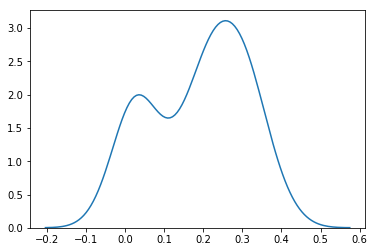

In [109]:
kdeplt2 = sns.kdeplot(sim[:,50])  

In [135]:
pred = predict(np.array(test_dataset.drop('MPG',axis=1)),sim)

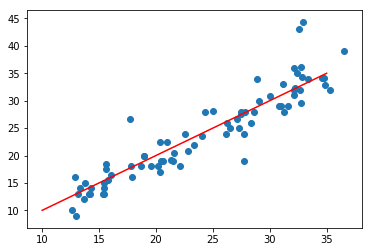

In [136]:
plt.plot(np.array([10,35]),np.array([10,35]),c='r')
plt.scatter(pred,test_dataset.MPG)
plt.show()

In [137]:
def rmse(u,v):
    return np.sqrt(np.mean((u-v)**2))

In [138]:
rmse(pred,test_dataset.MPG)

3.0318575616651886

In [151]:
nsim = sim.shape[0]
jump=100
rmses=np.zeros(np.int(nsim/jump))

for i in range(np.int(nsim/jump)):
    rmses[i]=rmse(test_dataset.MPG,predict(np.array(test_dataset.drop('MPG',axis=1)),sim[0:i*jump+1]))

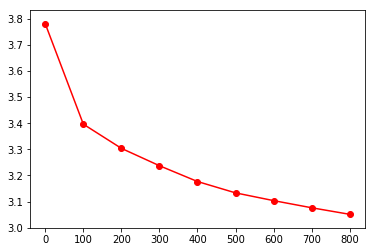

In [158]:
plt.scatter(np.arange(len(rmses))*jump,rmses,c='r')
plt.plot(np.arange(len(rmses))*jump,rmses,c='r')